<a href="https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/plot_full_mlo_record_keelingcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot full record of CO2 at Mauna Loa, Hawaii

### The Keeling Curve
https://keelingcurve.ucsd.edu

This notebook creates pdf and png plot versions.

## Import packages

In [1]:
import re
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
from matplotlib.path import Path
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from scipy.interpolate import CubicSpline
import matplotlib.transforms
from google.colab import files
from matplotlib import animation
from ipywidgets import widgets
from IPython.display import HTML
from base64 import b64encode
from PIL import Image
import urllib

%matplotlib inline

## Set directories and file names for data,  plot, and logo

In [2]:
# Read in data from github repository
# Get mlo record to last daily value
data_file = 'https://raw.githubusercontent.com/sio-co2o2/keelingcurve_notebooks/main/data/mlo/mlo_full_record_now_span.csv'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/ucsd_sio_logo.png'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_base_name = 'mlo_full_record'

pdf_file = plot_dir / f'{plot_base_name}.pdf'
png_file = plot_dir / f'{plot_base_name}.png'

## Load in Data and process

In [3]:
df = pd.read_csv(data_file,skipinitialspace=True,comment='"')
df.head()

,date,co2,date_seas_adj,co2_seas_adj,date_fit,co2_fit,date_seas_adj_fit,co2_seas_adj_fit
0,1958.202740,315.71,1958.202740,314.44,1958.202740,316.19,1958.202740,314.91
1,1958.287671,317.45,1958.287671,315.16,1958.287671,317.30,1958.287671,314.99
2,1958.369863,317.51,1958.369863,314.71,1958.369863,317.86,1958.369863,315.06
3,1958.536986,315.86,1958.536986,315.20,1958.454795,317.24,1958.454795,315.14
4,1958.621918,314.93,1958.621918,316.20,1958.536986,315.85,1958.536986,315.21


### Break into 2 dataframes. One for CO2 and one for the CO2 fit

In [4]:
df_co2 = df[['date', 'co2']].copy()
df_co2_fit = df[['date_fit', 'co2_fit']].copy()

### Remove rows with fill values -99.99 or NaN

In [5]:
df_co2 = df_co2[df_co2['co2'] != -99.99]
df_co2_fit = df_co2_fit[df_co2_fit['co2_fit'] != -99.99]

df_co2 = df_co2.dropna()
df_co2_fit = df_co2_fit.dropna()

df_co2.tail()

,date,co2
781,2022.172603,418.34
782,2022.173973,418.47
783,2022.176712,418.26
784,2022.179452,417.74
785,2022.182192,417.88


### Convert to numpy arrays for plotting

In [6]:
date_co2 = df_co2['date'].to_numpy()
co2 = df_co2['co2'].to_numpy()
date_co2_fit = df_co2_fit['date_fit'].to_numpy()
co2_fit = df_co2_fit['co2_fit'].to_numpy()

## Define plot functions

In [7]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
# Modified to add gradient below curve and have a bottom alpha

# def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
def gradient_fill(x, y, fill_color='#FFFFFF', xmin=None, ymin=None, xmax=None, 
                  ymax=None, alpha_bottom=None, ax=None, alpha=1, zorder=1, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    # Only want the gradient to show
    #line, = ax.plot(x, y, **kwargs)
    #if fill_color is None:
    #    fill_color = line.get_color()

    if alpha_bottom is None:
        alpha_bottom = 0

    if xmin is None:
        xmin = x.min()

    if ymin is None:
        ymin = y.min()
        
    if xmax is None:
        xmax = x.max()

    if ymax is None:
        ymax = y.max()
        
    if zorder is None:
        zorder = 1
        
    #zorder = line.get_zorder()
    
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    #z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]
    z[:, :, -1] = np.linspace(alpha_bottom, alpha, 100)[:, None]

    #xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)

In [8]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [9]:
def set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):

    # ------------------------------------
    # Set properties to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()

    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    # Allow room at top for the 2 titles
    fig.subplots_adjust(top=0.85)

    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='in', length=8, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)

    tick_spacing = 5
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    tick_spacing = 5
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')   
    
    # Display every other y major tick label
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    tick_length = 5
    ax.tick_params(axis='x',which='minor', direction='in', length=tick_length)
    
    tick_length = 4
    ax.tick_params(axis='y',which='minor', direction='in', length=tick_length)
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
      
    ax.set_xlabel(xlabel, fontweight='bold', fontsize=18, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=18, labelpad=5)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [10]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=14,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")
    ax.annotate(title2, xy=(0, 1.07), xycoords='axes fraction', fontsize=18,
                horizontalalignment='left', verticalalignment='top', fontweight = 'bold')

In [11]:
def add_inset_label(ax, label_start, today):
    label_text = f"{label_start} ending {today}"
    ax.annotate(label_text, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")

In [12]:
def add_sio_logo(fig, logo_file, xpos, ypos):

    logo = Image.open(urllib.request.urlopen(logo_file))

    fig.add_axes([xpos, ypos, 0.2, 0.2], anchor='SE', zorder=1)

    plt.imshow(logo)
    plt.axis('off')


In [13]:
def save_plot_for_website(fig, pdf_file, png_file):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 10
    height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    pdf_dpi = 300

    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=pdf_dpi)

    # For png
    # Want a png of height 500px

    # First save figure as a png and then scale to size needed

    png_dpi = 300

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # Now resize the image to be width 1000px for the
    # keelingcurve website
    img = Image.open(png_file)
    img_width, img_height = img.size

    height_px = 500
    img_scale = (height_px / img_height)
    width_px = int((float(img_width) * float(img_scale)))

    img = img.resize((width_px, height_px), Image.ANTIALIAS)
    img.save(png_file)


## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [14]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [15]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [16]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [17]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

### Set titles and axes labels

In [18]:
xlabel = ''
ylabel = "$\mathregular{CO}\\bf{_2}$" + " Concentration (ppm)"

title1 = get_data_end_date(date_co2)
title2 = 'Carbon dioxide concentration at Mauna Loa Observatory'

### Set yaxis min and max limits

In [19]:
ymin = 310
ymax = 430

### Set xaxis min and max limits

In [20]:
xmin = min(date_co2)

# Get current date as decimal year
now = datetime.now()
xmax = dt2t(now)

## Create plot and save

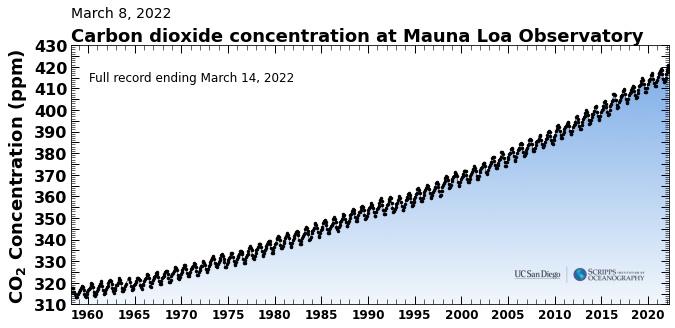

In [21]:
fig = plt.figure()

# Add padding for exterior plot text
ax = plt.axes([0.11, 0.12, 0.83, 0.54])


# ------------------------
# Add gradiant under curve
# ------------------------

# For gradient max, use last date of data rather than current date
xmax_gradient = max(date_co2)

#area_color = '#ACCAE6'
#area_color = '#8CB2E0'
area_color = '#73a7e6'

gradient_fill(date_co2, co2, fill_color=area_color, xmin=xmin, xmax=xmax_gradient,
              ymin=ymin, ymax=ymax, ax=ax, alpha_bottom=0.1, alpha=1.0)


# -------------
# Plot the data
# -------------

# Set plotting zorder above the gradient

ax.plot(date_co2, co2, 'o', color='black',markersize=3.5, 
         markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, zorder=5)

ax.plot(date_co2_fit, co2_fit, '-', color='black', linewidth=0.5, zorder=4)


# -------------------
# Set plot properties
# -------------------
set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)

# ------------------------------------------------
# Get todays date in various formats for labeling
# ------------------------------------------------
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)

# --------------
# Add inset text
# --------------
add_inset_label(ax, 'Full record', todays_date_modyyr)


# --------------------
# Add SIO logo to plot
# --------------------
xpos = 0.715
ypos = 0.155

add_sio_logo(fig, logo_file, xpos, ypos)


# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig, pdf_file, png_file)


plt.show()

## Download Plots (pdf & png)

In [22]:
def download_files(ev):
    files.download(png_file)
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())

# Create animation of the plot

In [23]:
# First set up the figure, the axis, and the plot element we want to animate
fig,ax = plt.subplots(1, 1, figsize = (10, 6))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    line.set_data(date_co2_fit[:i], co2_fit[:i])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames = len(date_co2_fit) + 1, interval=5, blit=True)

# Close plot so it isn't displayed
plt.close()

## Save the animation (It takes awhile to create)

In [24]:
# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


anim.save('mlo_anim.mp4')

## Load animation and press play

In [26]:
mlo_animation = open('mlo_anim.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mlo_animation).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)